## Montar Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Picpay'

In [ ]:
import sys
sys.path.append(path)

## Imports

In [42]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import ks_2samp
import shap
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## Funções

In [ ]:
from functions import calculate_psi, calculate_ks

## Base

In [6]:
base = pd.read_csv(f'{path}/base_modelo.csv').fillna(-999999999)
base['VAR_32'] = (base['VAR_32']*1000).round(2)
base['VAR_60'] = (base['VAR_60']*1000).round(2)
base

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,1,201404,0,0.0,0.0,0.0,0.0,1.245400e+02,3277.0,5.198000e+01,...,1.563800e+02,7.520000e+00,0.0,151.0,0.0,3.0,4.778400e+02,1.730600e+02,0.000000e+00,3.0
1,2,201407,0,64.0,0.0,2.0,1.0,4.792000e+01,2443.0,8.472000e+01,...,7.078400e+02,-1.000000e+09,-999999999.0,187.0,-999999999.0,-999999999.0,-1.000000e+09,1.846900e+02,5.400000e+01,-999999999.0
2,3,201405,0,99.0,2.0,2.0,2.0,8.038000e+01,1824.0,2.663000e+01,...,4.718600e+02,-1.000000e+09,-999999999.0,96.0,-999999999.0,-999999999.0,-1.000000e+09,7.320000e+02,1.219800e+02,-999999999.0
3,4,201412,0,0.0,0.0,0.0,0.0,1.058000e+01,3796.0,-1.000000e+09,...,1.199600e+02,2.300000e+01,0.0,417.0,0.0,0.0,-1.000000e+09,-1.000000e+09,0.000000e+00,0.0
4,5,201403,1,0.0,0.0,0.0,0.0,7.046000e+01,437.0,4.069000e+01,...,-1.000000e+09,-1.000000e+09,0.0,75.0,0.0,0.0,9.144500e+02,-1.000000e+09,-1.000000e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10733,10734,201406,0,44.0,0.0,0.0,1.0,1.074900e+02,515.0,1.833600e+02,...,-1.000000e+09,-1.000000e+09,-999999999.0,-67.0,-999999999.0,-999999999.0,-1.000000e+09,-1.000000e+09,-1.000000e+09,-999999999.0
10734,10735,201407,0,0.0,0.0,0.0,0.0,3.998000e+01,1029.0,-1.000000e+09,...,2.030700e+02,-1.000000e+09,2.0,404.0,2.0,2.0,3.243100e+02,0.000000e+00,6.111000e+01,2.0
10735,10736,201403,1,169.0,3.0,1.0,2.0,1.050800e+02,819.0,4.928000e+01,...,2.600000e+02,4.190000e+00,3.0,7.0,3.0,3.0,4.191600e+02,4.201600e+02,0.000000e+00,3.0
10736,10737,201402,1,46.0,0.0,0.0,1.0,2.657900e+02,1740.0,-1.000000e+09,...,4.477700e+02,-1.000000e+09,-999999999.0,6.0,-999999999.0,-999999999.0,-1.000000e+09,3.580800e+02,9.291000e+01,-999999999.0


In [7]:
ident = ['id', 'safra']
target = ['y']

variaveis = ['VAR_6',
'VAR_9',
'VAR_17',
'VAR_53',
'VAR_72',
'VAR_65',
'VAR_54',
'VAR_30',
'VAR_60',
'VAR_38',
'VAR_7',
'VAR_52',
'VAR_58',
'VAR_35',
'VAR_34',
'VAR_24',
'VAR_76',
'VAR_11',
'VAR_59',
'VAR_8',
'VAR_13',
'VAR_45',
'VAR_39',
'VAR_32']

In [16]:
for var in variaveis:
  base[var] = base[var].astype(int)

## Definições Iniciais

- Treino: Janeiro a Agosto/2014 (201401-201409)
- Teste: Setembro e Outubro/2014 (201410-201410)
- Validação: Novembro e Dezembro/2014 (201411-201412)

In [17]:
train_init, train_end = 201401, 201409
test_init, test_end = 201410, 201410
val_init, val_end = 201411, 201412

In [18]:
base_treino = base[base['safra'].between(train_init, train_end)]
base_teste = base[base['safra'].between(test_init, test_end)]
base_validacao = base[base['safra'].between(val_init, val_end)]

In [19]:
X_train, y_train = base_treino[variaveis], base_treino[target]
X_test, y_test = base_teste[variaveis], base_teste[target]
X_val, y_val = base_validacao[variaveis], base_validacao[target]

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled  = scaler.transform(X_val)

## Optimização de Hiperparâmetros

In [56]:
def objective(params):
    model = LogisticRegression(
        penalty=params['penalty'],
        C=params['C'],
        solver=params['solver'],
        random_state=42,
        max_iter=1000
    )
    model.fit(X_train_scaled, y_train)
    y_valid_prob = model.predict_proba(X_test_scaled)[:, 1]
    auc_val = roc_auc_score(y_test, y_valid_prob)
    return {'loss': -auc_val, 'status': STATUS_OK}

In [57]:
space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -5, 5),
    'solver': hp.choice('solver', ['liblinear'])
}

In [58]:
trials = Trials()

In [59]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(13)
)

  2%|▏         | 1/50 [00:00<00:06,  7.54trial/s, best loss: -0.6695392905051234]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



  8%|▊         | 4/50 [00:00<00:05,  9.08trial/s, best loss: -0.6695392905051234]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 12%|█▏        | 6/50 [00:00<00:04,  9.93trial/s, best loss: -0.6700916459063702]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 16%|█▌        | 8/50 [00:00<00:04, 10.39trial/s, best loss: -0.6700916459063702]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 20%|██        | 10/50 [00:00<00:03, 11.46trial/s, best loss: -0.6710216320411223]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 24%|██▍       | 12/50 [00:02<00:14,  2.68trial/s, best loss: -0.6710216320411223]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 34%|███▍      | 17/50 [00:04<00:09,  3.60trial/s, best loss: -0.6710216320411223]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

 38%|███▊      | 19/50 [00:04<00:07,  4.09trial/s, best loss: -0.6710216320411223]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 44%|████▍     | 22/50 [00:04<00:05,  5.16trial/s, best loss: -0.6710216320411223]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 48%|████▊     | 24/50 [00:04<00:04,  6.36trial/s, best loss: -0.6714809888288938]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 56%|█████▌    | 28/50 [00:05<00:02,  7.94trial/s, best loss: -0.6717261669916921]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 60%|██████    | 30/50 [00:05<00:02,  7.37trial/s, best loss: -0.6717261669916921]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 64%|██████▍   | 32/50 [00:06<00:03,  5.58trial/s, best loss: -0.6717261669916921]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 72%|███████▏  | 36/50 [00:06<00:01,  7.30trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 76%|███████▌  | 38/50 [00:06<00:01,  7.89trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|████████  | 40/50 [00:07<00:02,  4.53trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 86%|████████▌ | 43/50 [00:07<00:00,  7.04trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 88%|████████▊ | 44/50 [00:07<00:00,  7.40trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 94%|█████████▍| 47/50 [00:09<00:00,  3.80trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

 98%|█████████▊| 49/50 [00:09<00:00,  5.31trial/s, best loss: -0.6719093460788403]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|██████████| 50/50 [00:10<00:00,  4.85trial/s, best loss: -0.6719093460788403]


In [61]:
penalty_options = ['l1', 'l2']
solver_options = ['liblinear']

In [62]:
best_params = {}
best_params['penalty'] = penalty_options[best['penalty']]
best_params['C'] = best['C']
best_params['solver'] = solver_options[best['solver']]

In [63]:
print("Melhores hiperparâmetros encontrados:")
print(best_params)

Melhores hiperparâmetros encontrados:
{'penalty': 'l1', 'C': 0.015121965101048698, 'solver': 'liblinear'}


## Modelo

In [64]:
final_model = LogisticRegression(
    penalty=best_params['penalty'],
    C=best_params['C'],
    solver=best_params['solver'],
    random_state=42,
    max_iter=1000
)
final_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.015121965101048698, max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

## Treino do Modelo

In [65]:
y_test_prob = final_model.predict_proba(X_test_scaled)[:, 1]
auc_test = roc_auc_score(y_test, y_test_prob)

y_val_prob = final_model.predict_proba(X_val_scaled)[:, 1]
auc_val = roc_auc_score(y_val, y_val_prob)

In [66]:
print(f"AUC no Conjunto de Teste: {auc_test:.4f}")
print(f"AUC no conjunto de Validação: {auc_val:.4f}")

AUC no Conjunto de Teste: 0.6719
AUC no conjunto de Validação: 0.6872


In [67]:
y_train_prob = final_model.predict_proba(X_train)[:, 1]
y_test_prob = final_model.predict_proba(X_test)[:, 1]
y_val_prob = final_model.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [68]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred = (y_test_prob >= thresh).astype(int)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

In [69]:
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Melhor Threshold: {best_threshold:.2f}")
print(f"Melhor F1 Score: {best_f1:.4f}")

Melhor Threshold: 0.79
Melhor F1 Score: 0.4776


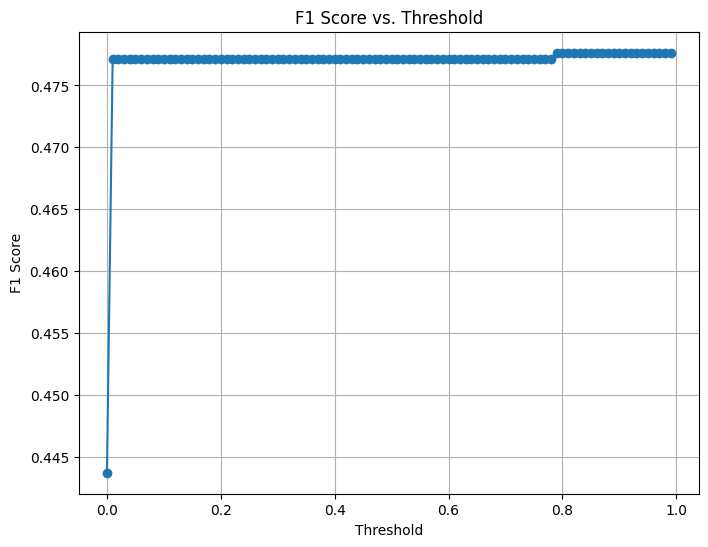

In [70]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.show()

In [71]:
y_train_pred = (y_train_prob >= best_threshold).astype(int)
y_test_pred = (y_test_prob >= best_threshold).astype(int)
y_val_pred = (y_val_prob >= best_threshold).astype(int)

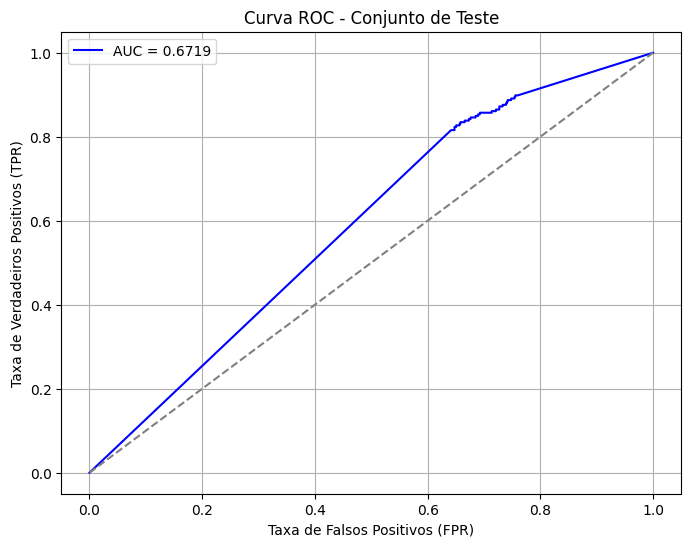

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Teste")
plt.legend()
plt.grid(True)
plt.show()

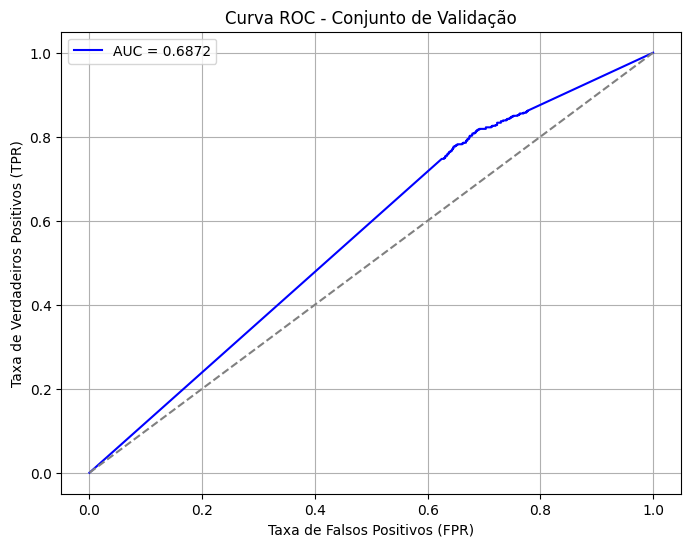

In [73]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Validação")
plt.legend()
plt.grid(True)
plt.show()

In [74]:
ks_train = calculate_ks(y_train.values.reshape(-1), y_train_prob)
ks_test = calculate_ks(y_test.values.reshape(-1), y_test_prob)
ks_val  = calculate_ks(y_val.values.reshape(-1),  y_val_prob)

In [75]:
ks_values = [ks_train, ks_test, ks_val]
groups = ['Treino', 'Teste', 'Validação']

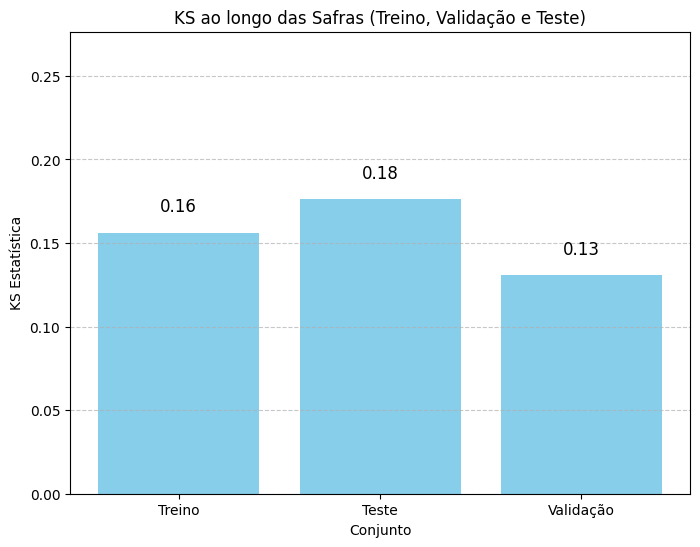

In [76]:
plt.figure(figsize=(8, 6))
bars = plt.bar(groups, ks_values, color='skyblue')
plt.xlabel("Conjunto")
plt.ylabel("KS Estatística")
plt.title("KS ao longo das Safras (Treino, Validação e Teste)")
for bar, ks_val in zip(bars, ks_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{ks_val:.2f}",
             ha='center', va='bottom', fontsize=12)

plt.ylim(0, max(ks_values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [79]:
s1 = sorted(base_treino["safra"].unique())
s2 = sorted(base_teste["safra"].unique())
s3 = sorted(base_validacao["safra"].unique())

safras = s1+s2+s3

ks_values = []

for safra in safras:
    y_true = base[base["safra"] == safra]["y"].values
    X_data = scaler.fit_transform(base[base["safra"] == safra][variaveis])

    y_pred_prob = final_model.predict_proba(X_data)[:, 1]

    y_pred_0 = y_pred_prob[y_true == 0]
    y_pred_1 = y_pred_prob[y_true == 1]

    if len(y_pred_0) > 0 and len(y_pred_1) > 0:
        ks_stat, _ = ks_2samp(y_pred_0, y_pred_1)
    else:
        ks_stat = np.nan

    ks_values.append(ks_stat)

In [83]:
[str(s) for s in safras]

['201401',
 '201402',
 '201403',
 '201404',
 '201405',
 '201406',
 '201407',
 '201408',
 '201409',
 '201410',
 '201411',
 '201412']

In [84]:
ks_values

[0.16801075268817203,
 0.25941157131568776,
 0.2537198456541654,
 0.28385909388007846,
 0.2722510737444909,
 0.31811278728358816,
 0.28602198573639454,
 0.2623280957614281,
 0.3314982474826916,
 0.26469096278928206,
 0.3388003393314068,
 0.2521047144184463]

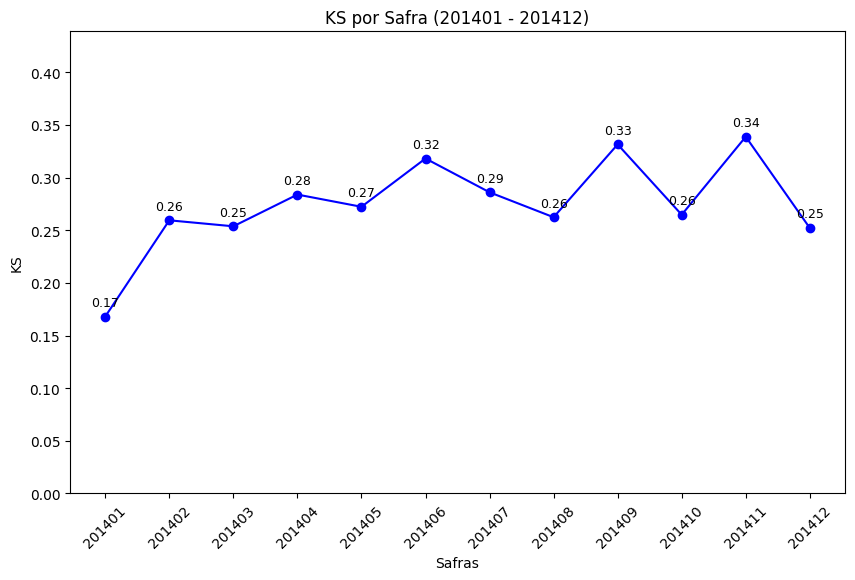

In [89]:
plt.figure(figsize=(10, 6))
plt.plot([str(s) for s in safras], ks_values, marker='o', linestyle='-', color='b')
plt.xlabel("Safras")
plt.ylabel("KS")
plt.title("KS por Safra (201401 - 201412)")
plt.xticks(rotation=45)
plt.ylim(0, max(ks_values) + 0.1)
for x, y in zip([str(s) for s in safras], ks_values):
    plt.text(x, y + 0.01, f"{y:.2f}", ha='center', fontsize=9)
plt.show()

In [90]:
cm = confusion_matrix(y_val, y_val_pred)
print("Matriz de Confusão (com best_threshold):")
print(cm)

print("\nRelatório de Classificação (com best_threshold):")
print(classification_report(y_val, y_val_pred))

Matriz de Confusão (com best_threshold):
[[386 662]
 [136 410]]

Relatório de Classificação (com best_threshold):
              precision    recall  f1-score   support

           0       0.74      0.37      0.49      1048
           1       0.38      0.75      0.51       546

    accuracy                           0.50      1594
   macro avg       0.56      0.56      0.50      1594
weighted avg       0.62      0.50      0.50      1594



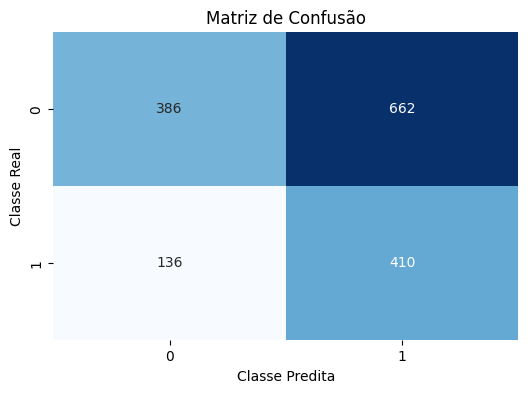

In [92]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão")
plt.show()

In [95]:
importance = final_model.coef_[0]

importance_df = pd.DataFrame({'Feature': variaveis, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=True, inplace=True)
importance_df

,Feature,Importance
8,VAR_60,-0.277802
23,VAR_32,-0.275645
2,VAR_17,-0.138989
6,VAR_54,-0.127927
3,VAR_53,-0.052051
15,VAR_24,-0.006352
16,VAR_76,-0.005912
12,VAR_58,-0.000173
18,VAR_59,-0.000070
21,VAR_45,0.000000


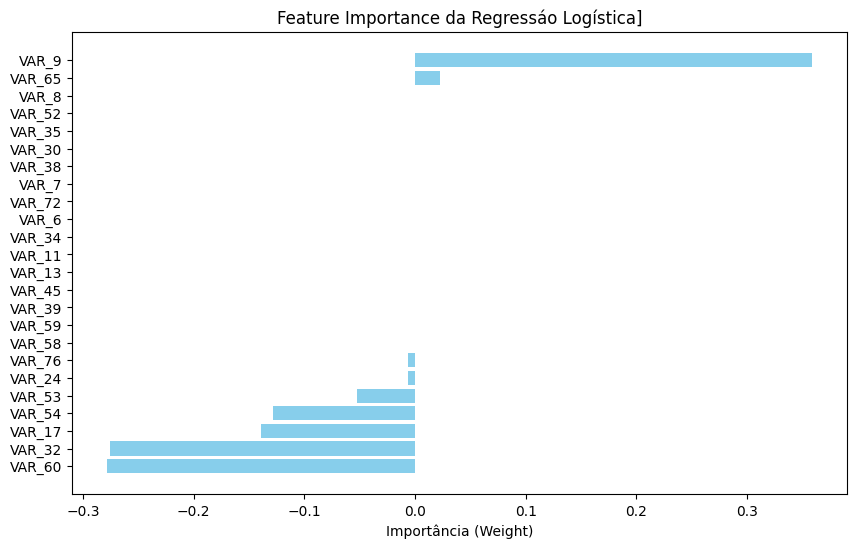

In [97]:
importance_df.sort_values(by='Importance', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importância (Weight)")
plt.title("Feature Importance da Regressáo Logística]")
plt.show()

In [112]:
importance_df[importance_df['Importance'] != 0]['Feature'].to_list()

['VAR_60',
 'VAR_32',
 'VAR_17',
 'VAR_54',
 'VAR_53',
 'VAR_24',
 'VAR_76',
 'VAR_58',
 'VAR_59',
 'VAR_65',
 'VAR_9']

# Monitoramento

In [100]:
psi_teste = {var: calculate_psi(base_treino[var].dropna(), base_teste[var].dropna()) for var in variaveis}
psi_val = {var: calculate_psi(base_treino[var].dropna(), base_validacao[var].dropna()) for var in variaveis}

In [101]:
psi_df = pd.DataFrame({'Teste': psi_teste, 'Validacao': psi_val})
psi_df.sort_values('Teste', ascending=False)

,Teste,Validacao
VAR_32,0.03,0.07
VAR_9,0.00,0.00
VAR_39,0.00,0.00
VAR_45,0.00,0.00
VAR_13,0.00,0.00
VAR_8,0.00,0.00
VAR_59,0.00,0.00
VAR_11,0.00,0.00
VAR_76,0.00,0.00
VAR_24,0.00,0.00
